### Object Detection and Non-Maxima Suppression

Approach:
    
    Import the required libraries
    Choose 10 images and their corresponding annotation data from the dataset
    Plot the ground truth(Annotated bounding box on the image)
    Create a distorted bounding boxex from the ground truth bounding box
    Apply Non-Maxima Suppression to pick the best bounding box

Importing the libraries to be used

In [1]:
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random

Function to plot the ground truth bounding box on the image.

Get the bounding box information from the xml file and plotting the bounding box on the corresponding image

In [2]:
def plot_ground_truth(image_path, xml_path):
    img = plt.imread(image_path)
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for obj in root.findall('object'):
        xmin = int(obj.find('bndbox').find('xmin').text)
        ymin = int(obj.find('bndbox').find('ymin').text)
        xmax = int(obj.find('bndbox').find('xmax').text)
        ymax = int(obj.find('bndbox').find('ymax').text)
        
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    
    ax.axis('off')
    plt.show()

Function to create distorted bounding boxes from the ground truth bounding box.

As the aim is to study non-maxima suppression and we have only the ground truth bb information, we are creating more bounding boxes from the existing information.

In [3]:
def distort_bounding_boxes(image_path, xml_path):
    img = plt.imread(image_path)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    fig, ax = plt.subplots(1)
    ax.imshow(img)

    boxes = []
    labels = [] 
    for obj in root.findall('object'):
        label = obj.find('name').text
        labels.append(label)
        
        xmin = int(obj.find('bndbox').find('xmin').text)
        ymin = int(obj.find('bndbox').find('ymin').text)
        xmax = int(obj.find('bndbox').find('xmax').text)
        ymax = int(obj.find('bndbox').find('ymax').text)
        
        # Original bounding box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        
        # Distorted bounding box 1
        xmin_distorted1 = max(0, xmin + random.uniform(-20, 20))
        ymin_distorted1 = max(0, ymin + random.uniform(-20, 20))
        xmax_distorted1 = min(img.shape[1], xmax + random.uniform(-20, 20))
        ymax_distorted1 = min(img.shape[0], ymax + random.uniform(-20, 20))
        rect = patches.Rectangle((xmin_distorted1, ymin_distorted1), xmax_distorted1 - xmin_distorted1, ymax_distorted1 - ymin_distorted1, linewidth=2, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        
        # Distorted bounding box 2
        xmin_distorted2 = max(0, xmin + random.uniform(-20, 20))
        ymin_distorted2 = max(0, ymin + random.uniform(-20, 20))
        xmax_distorted2 = min(img.shape[1], xmax + random.uniform(-20, 20))
        ymax_distorted2 = min(img.shape[0], ymax + random.uniform(-20, 20))
        rect = patches.Rectangle((xmin_distorted2, ymin_distorted2), xmax_distorted2 - xmin_distorted2, ymax_distorted2 - ymin_distorted2, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        # Append distorted bounding boxes to list
        labels.append(label)
        boxes.append([xmin_distorted1, ymin_distorted1, xmax_distorted1, ymax_distorted1])
        labels.append(label)
        boxes.append([xmin_distorted2, ymin_distorted2, xmax_distorted2, ymax_distorted2])
    
    ax.axis('off')
    plt.show()
    return boxes, labels

Function to calculate the overlap percentage or the iou of two bounding boxes.

    First calculate the union area and the intersection area of the two bounding boxes.
    Then calculate the iou by dividing the intersection are by the union area.

In [4]:
def calculate_intersection_area(box1, box2):
    # Calculate the intersection area of two bounding boxes
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # Check for non-overlapping rectangles
    if x1 >= x2 or y1 >= y2:
        return 0
    
    intersection_area = (x2 - x1) * (y2 - y1)
    return intersection_area

def calculate_union_area(box1, box2):
    # Calculate the union area of two bounding boxes
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    intersection_area = calculate_intersection_area(box1, box2)
    union_area = area_box1 + area_box2 - intersection_area
    return union_area


def calculate_iou(box1, box2):
    # Calculate the percentage overlap of two bounding boxes
    intersection_area = calculate_intersection_area(box1, box2)
    union_area = calculate_union_area(box1, box2)
    iou = intersection_area / union_area
    return iou

Function for Non-Maxima Suppression
    
    The bounding boxes are sorted in descending order based on their confidence score and so their corresponding labels.
    Suppress the box that has iou greater than the threshold with the bounding box which has higher confidence for the same label.

In [5]:
def non_max_suppression(boxes, scores, labels, threshold):
    if len(boxes) == 0:
        return []
    
    # Convert boxes, scores, and labels to numpy arrays for sorting operation
    boxes = np.array(boxes)
    scores = np.array(scores)
    labels = np.array(labels)
    
    # Sort boxes by scores in descending order
    scores_indices = np.argsort(scores)[::-1]
    boxes = boxes[scores_indices]
    labels = labels[scores_indices]
    
    selected_boxes = []
    selected_indices = []
    
    # Looping through each box
    for i in range(len(boxes)):
        if i in selected_indices:
            continue
        
        selected_indices.append(i)
        selected_boxes.append(boxes[i])
        
        # Compare with other boxes
        for j in range(i + 1, len(boxes)):
            # Check if boxes have the same label
            if labels[i] == labels[j]:
                iou = calculate_iou(boxes[i], boxes[j])
                # Apply NMS only if IoU exceeds threshold and labels match
                if iou > threshold:
                    selected_indices.append(j)
    
    return selected_boxes

Function to plot the final bounding box resulted from the nms

In [12]:
def apply_nms_and_plot(image_path, distorted_boxes, labels):
    img = plt.imread(image_path)
    
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Apply non-maxima suppression
    nms_threshold = 0.4  # You can adjust this threshold
    selected_boxes = non_max_suppression(distorted_boxes, [1]*len(distorted_boxes), labels, nms_threshold)

    # Visualize selected boxes after NMS
    for box in selected_boxes:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    ax.axis('off')
    plt.show()

Function to convert synset id information to its corresponding label

In [13]:
def label(i):
    if i == "n07764155":
        return "Mango"
    elif i == "n02352591":
        return "Mouse"
    else:
        return "Pencil"
    return None

Ground truth bounding box


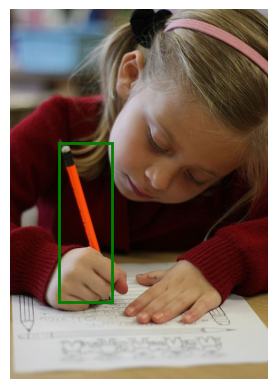

Distorted bounding boxes


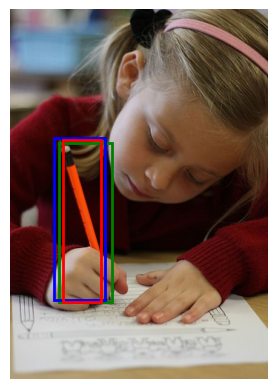

final bounding box after nms


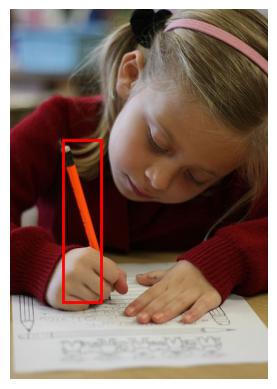

-------------------------------------------------------------------
Ground truth bounding box


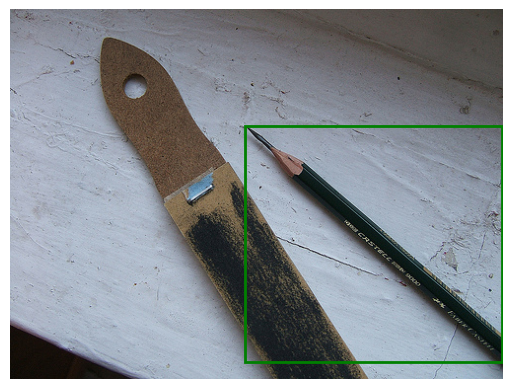

Distorted bounding boxes


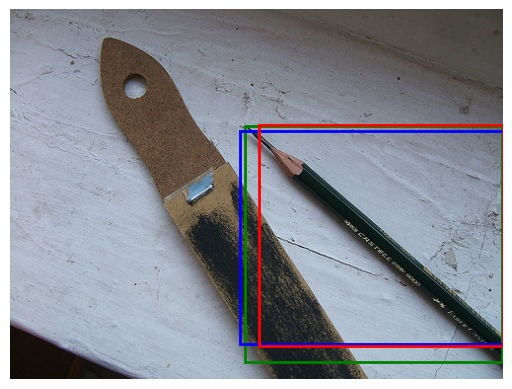

final bounding box after nms


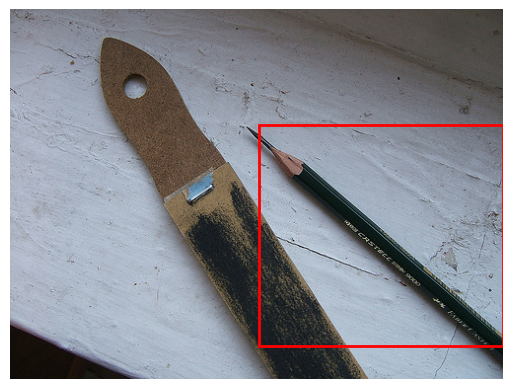

-------------------------------------------------------------------
Ground truth bounding box


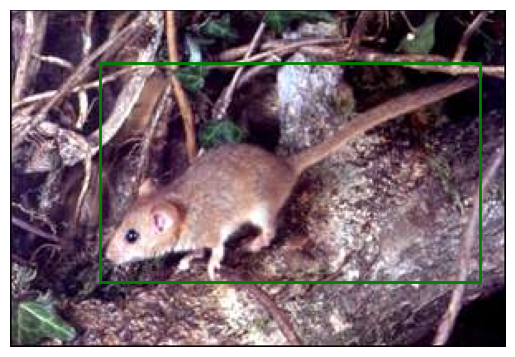

Distorted bounding boxes


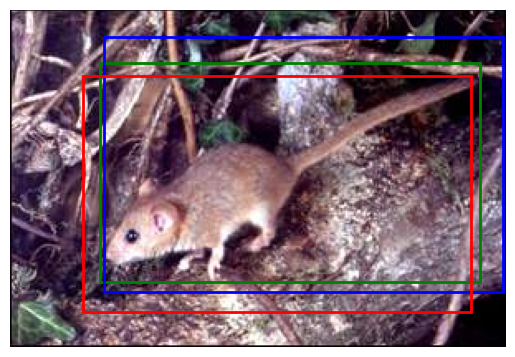

final bounding box after nms


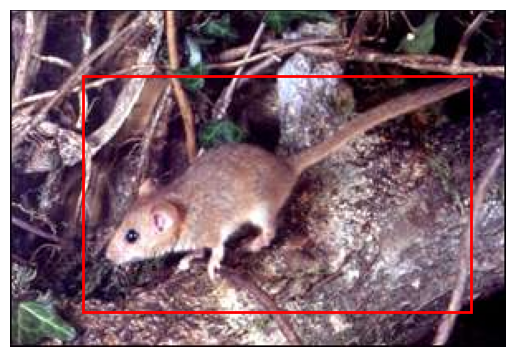

-------------------------------------------------------------------
Ground truth bounding box


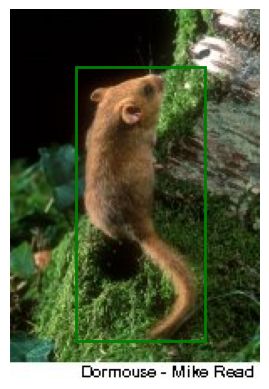

Distorted bounding boxes


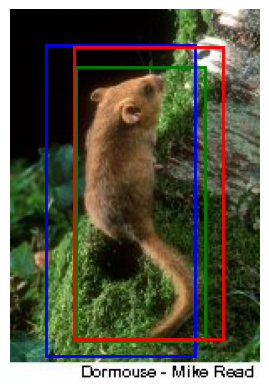

final bounding box after nms


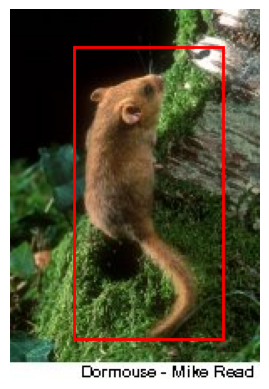

-------------------------------------------------------------------
Ground truth bounding box


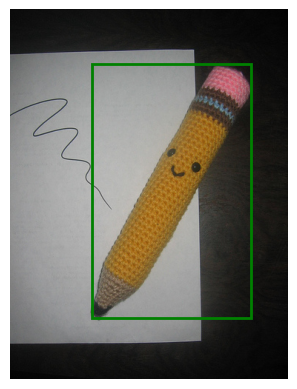

Distorted bounding boxes


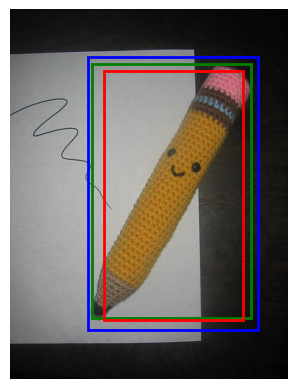

final bounding box after nms


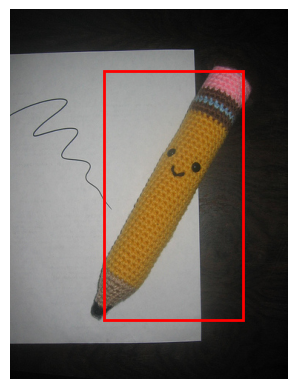

-------------------------------------------------------------------
Ground truth bounding box


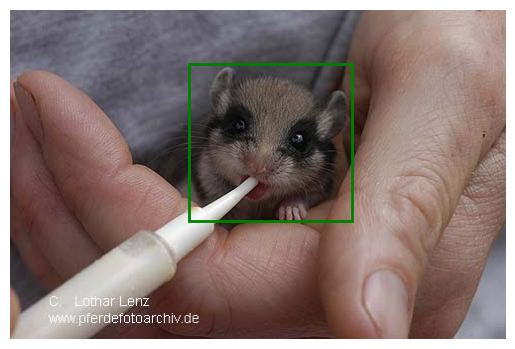

Distorted bounding boxes


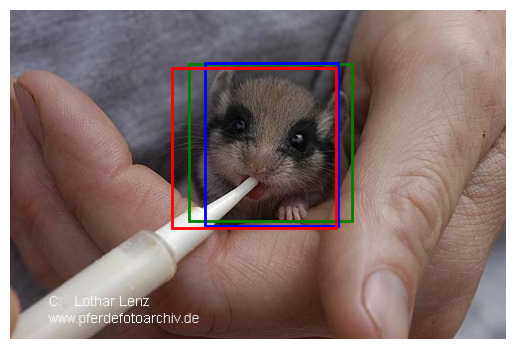

final bounding box after nms


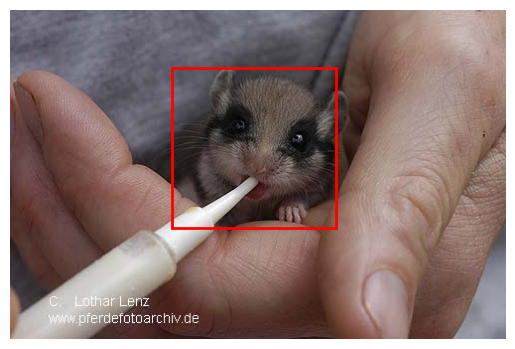

-------------------------------------------------------------------
Ground truth bounding box


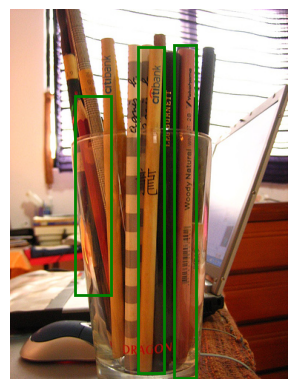

Distorted bounding boxes


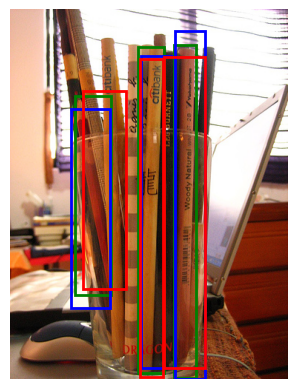

final bounding box after nms


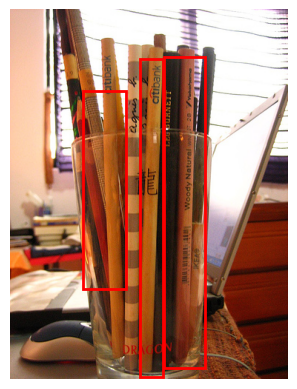

-------------------------------------------------------------------
Ground truth bounding box


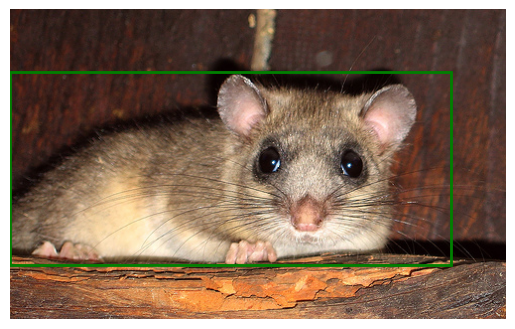

Distorted bounding boxes


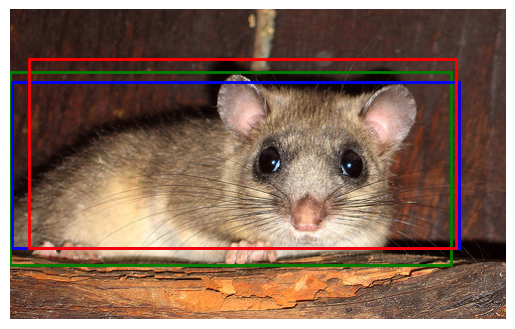

final bounding box after nms


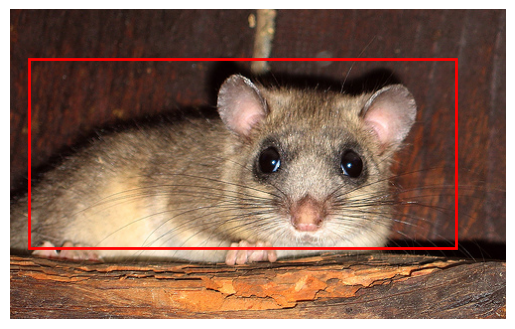

-------------------------------------------------------------------
Ground truth bounding box


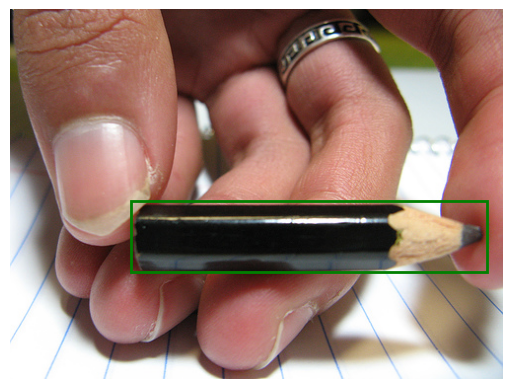

Distorted bounding boxes


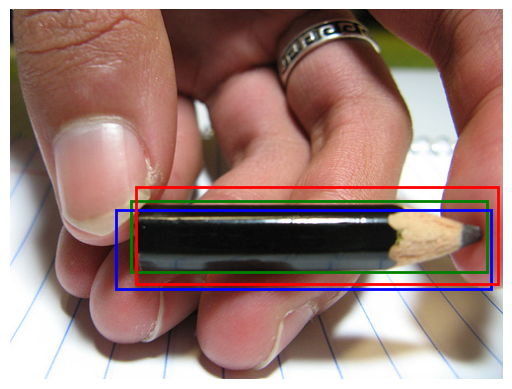

final bounding box after nms


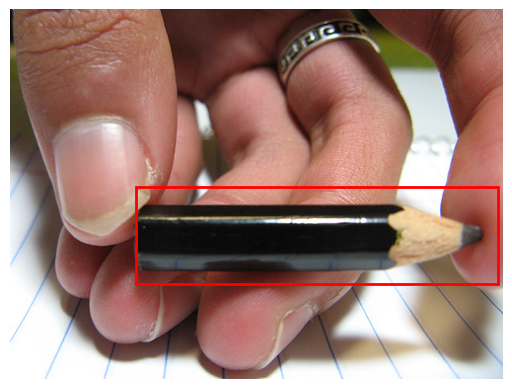

-------------------------------------------------------------------
Ground truth bounding box


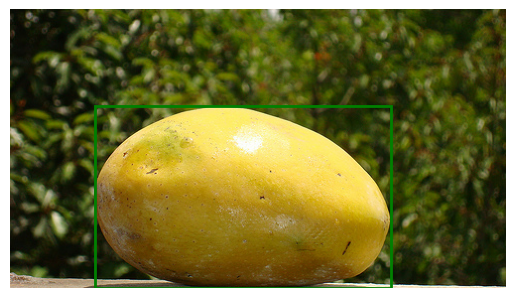

Distorted bounding boxes


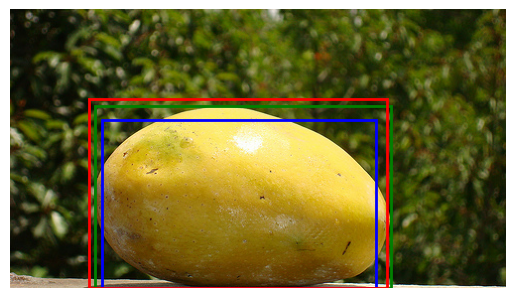

final bounding box after nms


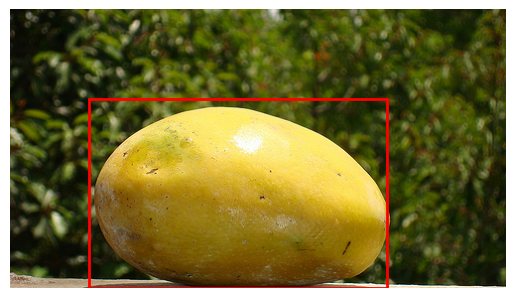

-------------------------------------------------------------------


In [14]:
random_image_folder = "Organised_Data/images"
random_images = os.listdir(random_image_folder)
images = os.listdir("Organised_Data/images")
random_images = random.sample(images, 10)
for image in random_images:
    image_path = os.path.join(random_image_folder, image)
    xml_path = os.path.join("Organised_Data/annot_files", os.path.splitext(image)[0] + ".xml")
    print("Ground truth bounding box")
    plot_ground_truth(image_path, xml_path)
    print("Distorted bounding boxes")
    distorted_boxes, labels = distort_bounding_boxes(image_path, xml_path)
    for i in range(len(labels)):
        labels[i] = label(labels[i])
    print("final bounding box after nms")
    apply_nms_and_plot(image_path, distorted_boxes, labels)
    print("-------------------------------------------------------------------")
